In [1]:
from __future__ import annotations

from ast import literal_eval
import sys; sys.path.append("../utils")
import _confusion_matrix

from IPython.display import display as ipy_display
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
from matplotlib import pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GroupShuffleSplit
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

%config InlineBackend.figure_format = 'svg'

In [2]:
def encode_labels(df: pd.DataFrame, y_column: str) -> tuple[pd.DataFrame, dict]:
    """Encode labels to be used by the classifier."""
    enc = LabelEncoder()
    enc.fit(df[y_column])
    encoded_labels = dict(zip(enc.classes_, enc.transform(enc.classes_))) # will use that in the cm later
    df['label'] = enc.transform(df['label'])
    return df, encoded_labels

In [3]:
RAW_DATA_FILES = "../../data/reddit_ell_eng_raw_pos{}.csv"
RAW_DATA_MAXLEN = ['none', '300', '200']

In [4]:
models_df = pd.DataFrame({
    'model': [
        'LSVM', 
        'LogReg'
    ],
    'base': [
        SGDClassifier(loss='hinge'),
        SGDClassifier(loss='log_loss'), # 'log' is deprecated in 1.1
    ],
    'word_params': [
        {
            'cxf__words__ngram_range': [(1, 1), (2, 2), (3, 3), (4, 4), (5, 5)],
        },
        {
            'cxf__words__ngram_range': [(1, 1), (2, 2), (3, 3), (4, 4), (5, 5)],
        },
    ],
    'char_params': [
        {
            'cxf__chars__ngram_range': [(1, 1), (2, 2), (3, 3), (4, 4), (5, 5)],
        },
        {
            'cxf__chars__ngram_range': [(1, 1), (2, 2), (3, 3), (4, 4), (5, 5)],
        },
    ],
    'pos_tags_params': [
        {
            'cxf__postg__ngram_range': [(1, 1), (2, 2), (3, 3), (4, 4), (5, 5)],
        },
        {
            'cxf__postg__ngram_range': [(1, 1), (2, 2), (3, 3), (4, 4), (5, 5)],
        },
    ],
})

In [5]:
all_results = pd.DataFrame()

(7895, 2) (2029, 2) (7895,) (2029,)

======================================LSVM====================================== ======================================none======================================
-------------------------------------WORDS--------------------------------------
Fitting 10 folds for each of 5 candidates, totalling 50 fits
              precision    recall  f1-score   support

           0       0.78      0.69      0.73      1041
           1       0.71      0.80      0.75       988

    accuracy                           0.74      2029
   macro avg       0.75      0.74      0.74      2029
weighted avg       0.75      0.74      0.74      2029


Saved confusion matrix: ../results/figures/sgd_0.743_words_20221229_1133.svg
-------------------------------------CHARS--------------------------------------
Fitting 10 folds for each of 5 candidates, totalling 50 fits
              precision    recall  f1-score   support

           0       0.79      0.67      0.73      1041
   

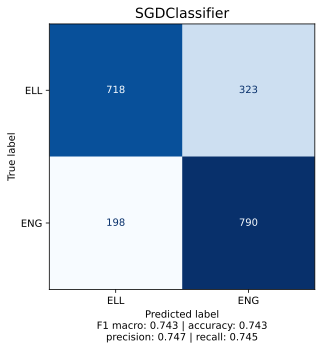

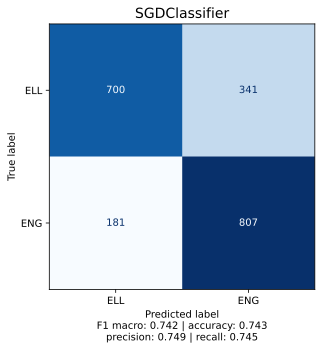

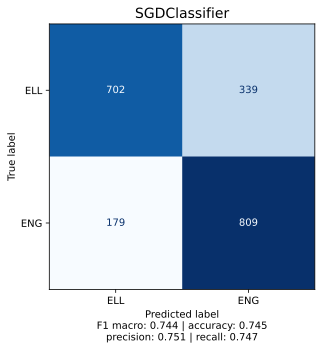

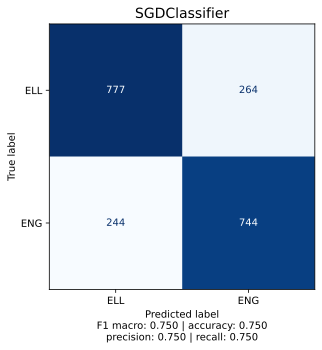

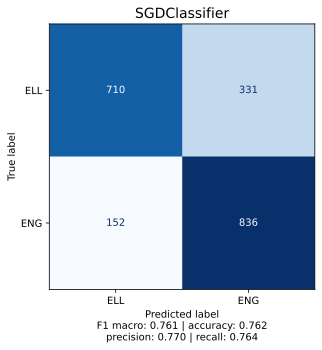

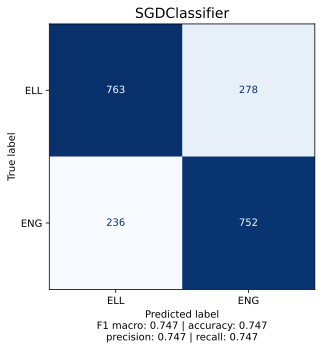

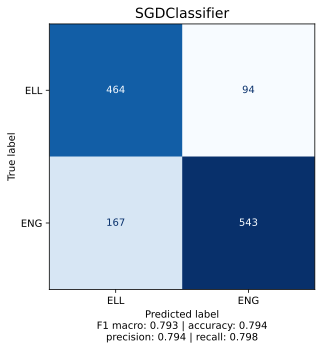

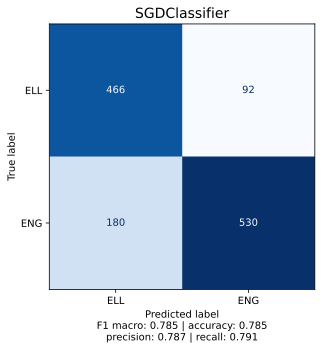

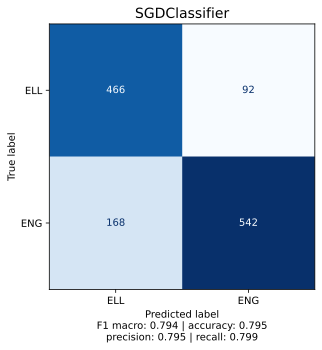

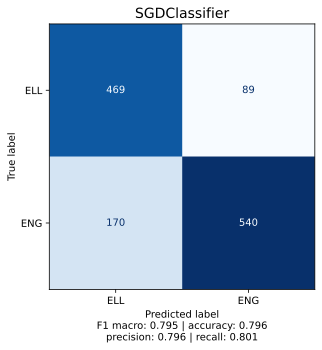

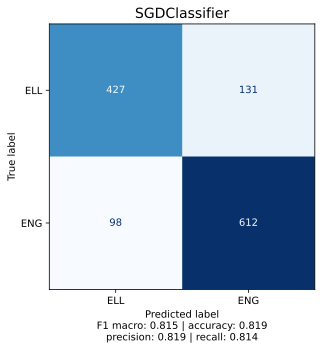

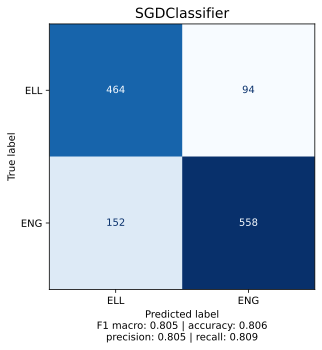

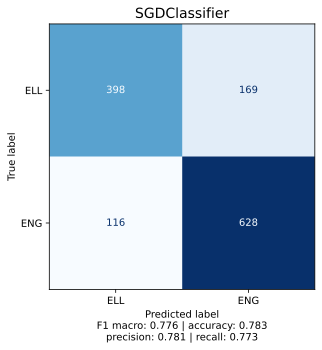

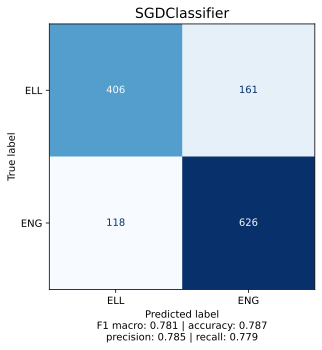

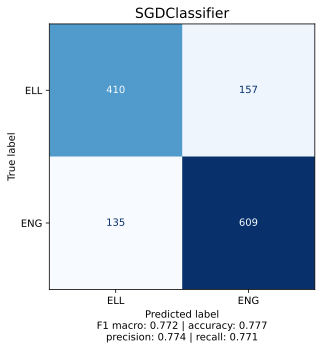

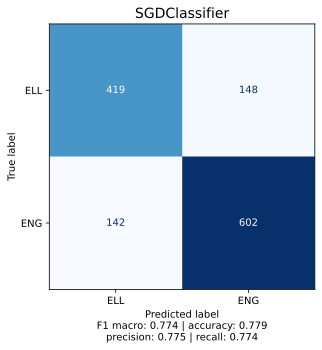

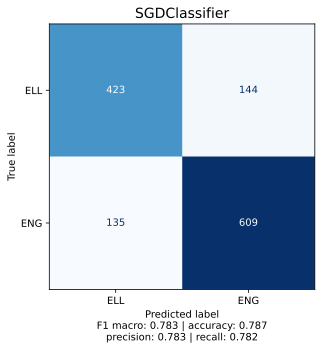

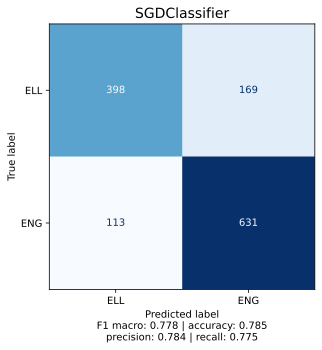

In [6]:
for maxlen in RAW_DATA_MAXLEN:
    df = pd.read_csv(RAW_DATA_FILES.format(f"_{maxlen}" if maxlen != 'none' else ''),
                                           encoding='utf-8')

    df, labels = encode_labels(df, 'label')

    X = df[['text', 'pos_tags']]
    y = df['label']

    gss = GroupShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
    train_idx, test_idx = next(gss.split(X, y, groups=df['user_id']))
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    print(X_train.shape, X_test.shape, y_train.shape, y_test.shape, end="\n\n")


    # run cross-validation, each time using only one of the three features
    word_vect = TfidfVectorizer(analyzer='word', ngram_range=(1, 1))
    char_vect = TfidfVectorizer(analyzer='char', ngram_range=(2, 2))
    post_vect = TfidfVectorizer(analyzer='word', ngram_range=(1, 1))

    for i, row in models_df.iterrows():
        model = row['model']
        base = row['base']
        word_params = row['word_params']
        char_params = row['char_params']
        pos_tags_params = row['pos_tags_params']

        cxf = ColumnTransformer(
            [
                ('words', word_vect, 'text'),
                ('chars', char_vect, 'text'),
                ('postg', post_vect, 'pos_tags'),
            ],
            remainder='drop',
        )

        pipe = Pipeline([
            ('cxf', cxf),
            ('clf', base),
        ])


        print(f"{model:=^80} {maxlen:=^80}")
        print("WORDS".center(80, "-"))
        word_grid = GridSearchCV(pipe, word_params, cv=10, scoring='f1_macro', n_jobs=-1, verbose=5)
        word_grid.fit(X_train, y_train)
        y_pred = word_grid.predict(X_test)
        report = classification_report(y_test, y_pred, output_dict=True)
        print(classification_report(y_test, y_pred), end="\n\n")
        cm = confusion_matrix(y_test, y_pred)
        _confusion_matrix.plot_cm(cm, pipe=pipe, report=report, labels=labels, colorbar=False, export=True, comment='words')
        word_results = pd.DataFrame(word_grid.cv_results_)
        word_results['model'] = model
        word_results['maxlen'] = maxlen
        word_results['feature'] = 'words'
        all_results = pd.concat([all_results, word_results])


        print("CHARS".center(80, "-"))
        char_grid = GridSearchCV(pipe, char_params, cv=10, scoring='f1_macro', n_jobs=-1, verbose=5)
        char_grid.fit(X_train, y_train)
        y_pred = char_grid.predict(X_test)
        report = classification_report(y_test, y_pred, output_dict=True)
        print(classification_report(y_test, y_pred), end="\n\n")
        cm = confusion_matrix(y_test, y_pred)
        _confusion_matrix.plot_cm(cm, pipe=pipe, report=report, labels=labels, colorbar=False, export=True, comment='chars')
        word_results = pd.DataFrame(char_grid.cv_results_)
        word_results['model'] = model
        word_results['maxlen'] = maxlen
        word_results['feature'] = 'chars'
        all_results = pd.concat([all_results, word_results])


        print("POS tags".center(80, "-"))
        post_grid = GridSearchCV(pipe, pos_tags_params, cv=10, scoring='f1_macro', n_jobs=-1, verbose=5)
        post_grid.fit(X_train, y_train)
        y_pred = post_grid.predict(X_test)
        report = classification_report(y_test, y_pred, output_dict=True)
        print(classification_report(y_test, y_pred), end="\n\n")
        cm = confusion_matrix(y_test, y_pred)
        _confusion_matrix.plot_cm(cm, pipe=pipe, report=report, labels=labels, colorbar=False, export=True, comment='pos_tags')
        word_results = pd.DataFrame(post_grid.cv_results_)
        word_results['model'] = model
        word_results['maxlen'] = maxlen
        word_results['feature'] = 'pos_tags'
        all_results = pd.concat([all_results, word_results])

        print(f"{model} done", end="\n\n")

In [7]:
# sort values in params column
all_results['params'] = all_results['params'].apply(lambda x: str(x))
all_results = all_results.sort_values(by='params')
all_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_cxf__words__ngram_range,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score,model,maxlen,feature,param_cxf__chars__ngram_range,param_cxf__postg__ngram_range
0,2.718616,0.126206,0.263722,0.014850,NaN,"{'cxf__chars__ngram_range': (1, 1)}",0.748421,0.718553,0.808659,0.750800,...,0.765702,0.743999,0.767587,0.029265,5,LogReg,300,chars,"(1, 1)",NaN
0,2.652322,0.270391,0.273077,0.025259,NaN,"{'cxf__chars__ngram_range': (1, 1)}",0.798368,0.760046,0.797861,0.742155,...,0.787191,0.808373,0.770428,0.027331,5,LogReg,200,chars,"(1, 1)",NaN
0,2.507671,0.204098,0.273556,0.030801,NaN,"{'cxf__chars__ngram_range': (1, 1)}",0.729003,0.778421,0.712600,0.768191,...,0.852967,0.823826,0.769639,0.049332,1,LSVM,none,chars,"(1, 1)",NaN
0,2.399443,0.117710,0.259124,0.029939,NaN,"{'cxf__chars__ngram_range': (1, 1)}",0.723749,0.783477,0.720217,0.795539,...,0.773395,0.817361,0.762245,0.041150,5,LogReg,none,chars,"(1, 1)",NaN
0,2.733803,0.183408,0.275064,0.030811,NaN,"{'cxf__chars__ngram_range': (1, 1)}",0.751412,0.728300,0.809394,0.737955,...,0.761620,0.746201,0.767345,0.032542,2,LSVM,300,chars,"(1, 1)",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,6.229690,0.637958,0.227245,0.063815,"(5, 5)","{'cxf__words__ngram_range': (5, 5)}",0.692559,0.756738,0.683329,0.745810,...,0.808614,0.761705,0.736278,0.053506,4,LSVM,none,words,NaN,NaN
4,6.357350,0.882595,0.229216,0.071280,"(5, 5)","{'cxf__words__ngram_range': (5, 5)}",0.736413,0.717783,0.800289,0.711459,...,0.720900,0.697414,0.736801,0.031337,5,LSVM,300,words,NaN,NaN
4,6.262923,0.821660,0.250234,0.081377,"(5, 5)","{'cxf__words__ngram_range': (5, 5)}",0.759572,0.730320,0.785519,0.724940,...,0.769972,0.789942,0.742884,0.034769,5,LSVM,200,words,NaN,NaN
4,5.575279,0.850304,0.238499,0.082323,"(5, 5)","{'cxf__words__ngram_range': (5, 5)}",0.764567,0.735850,0.787860,0.721442,...,0.775948,0.801633,0.746232,0.033937,3,LogReg,200,words,NaN,NaN


In [8]:
all_results = all_results.reset_index(drop=True)
all_results.to_csv('all_results_lsvm_logreg_single_feats.csv', index=False, encoding='utf-8')

In [9]:
import pandas as pd
from ast import literal_eval
from IPython.display import display as ipy_display

with pd.option_context('display.max_rows', None):
    all_res = all_results[['model', 'maxlen', 'feature', 'params', 'mean_test_score', 'std_test_score', 'rank_test_score']]
    all_res['feature'] = all_res['feature'].str.replace('words', 'Words').str.replace('chars', 'Characters').str.replace('pos_tags', 'POS')
    all_res['params'] = all_res['params'].apply(lambda x: literal_eval(x))
    all_res['params'] = all_res['params'].apply(lambda x: "".join("n = " + str(val).removeprefix('(').removesuffix(')')
                                                                  for val in x.values()))
    all_res = all_res.rename(columns={'params': 'n_grams', 'mean_test_score': 'F1-score', 'std_test_score': 'std',})
    all_res = all_res.sort_values(by=['model', 'maxlen', 'feature', 'n_grams'])
    all_res = all_res.groupby(['model', 'maxlen', 'feature', 'n_grams']).agg({'F1-score': 'mean', 'std': 'mean'})
    all_res = all_res.unstack('model')  # move model to columns and group by model
    all_res = all_res.swaplevel(axis=1).sort_index(axis=1)  # swap F1-score and std columns with model

    ipy_display(all_res)

all_res.to_latex('all_results_lsvm_logreg_single_feats.tex', encoding='utf-8')

C:\Users\dimboump\AppData\Local\Temp\ipykernel_42092\4106528570.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_res['feature'] = all_res['feature'].str.replace('words', 'Words').str.replace('chars', 'Characters').str.replace('pos_tags', 'POS')
C:\Users\dimboump\AppData\Local\Temp\ipykernel_42092\4106528570.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_res['params'] = all_res['params'].apply(lambda x: literal_eval(x))
C:\Users\dimboump\AppData\Local\Temp\ipykernel_42092\4106528570.py:9: Set

model                           LSVM              LogReg          
                            F1-score       std  F1-score       std
maxlen feature    n_grams                                         
200    Characters n = 1, 1  0.769978  0.023487  0.770428  0.027331
                  n = 2, 2  0.774178  0.025394  0.779267  0.027604
                  n = 3, 3  0.767174  0.024994  0.781519  0.025616
                  n = 4, 4  0.767094  0.023817  0.783484  0.022300
                  n = 5, 5  0.770011  0.028266  0.781971  0.024153
       POS        n = 1, 1  0.774693  0.026639  0.774339  0.029004
                  n = 2, 2  0.770661  0.029590  0.777937  0.031645
                  n = 3, 3  0.762433  0.029255  0.775019  0.027897
                  n = 4, 4  0.760854  0.029124  0.779228  0.028308
                  n = 5, 5  0.768335  0.027229  0.781544  0.029300
       Words      n = 1, 1  0.774031  0.029857  0.775871  0.030108
                  n = 2, 2  0.766398  0.026805  0.763405  0.028718
                  n = 3, 3  0.753791  0.031193  0.743964  0.029368
                  n = 4, 4  0.748353  0.031075  0.745585  0.029295
                  n = 5, 5  0.742884  0.034769  0.746232  0.033937
300    Characters n = 1, 1  0.767345  0.032542  0.767587  0.029265
                  n = 2, 2  0.769768  0.028641  0.773338  0.030621
                  n = 3, 3  0.766507  0.027666  0.776305  0.029716
                  n = 4, 4  0.759308  0.029363  0.776904  0.032194
                  n = 5, 5  0.760434  0.027685  0.777756  0.029639
       POS        n = 1, 1  0.773648  0.027373  0.771870  0.032056
                  n = 2, 2  0.763887  0.034457  0.769679  0.034955
                  n = 3, 3  0.754155  0.033891  0.770064  0.032533
                  n = 4, 4  0.749475  0.029220  0.771715  0.027733
                  n = 5, 5  0.762025  0.032657  0.770821  0.026698
       Words      n = 1, 1  0.773865  0.029172  0.771164  0.029523
                  n = 2, 2  0.756949  0.027414  0.754350  0.035560
                  n = 3, 3  0.745487  0.034301  0.735971  0.029188
                  n = 4, 4  0.739667  0.030950  0.733744  0.035434
                  n = 5, 5  0.736801  0.031337  0.733479  0.035260
none   Characters n = 1, 1  0.769639  0.049332  0.762245  0.041150
                  n = 2, 2  0.769628  0.043965  0.773540  0.046331
                  n = 3, 3  0.766676  0.046127  0.775846  0.048555
                  n = 4, 4  0.763634  0.047004  0.777058  0.052771
                  n = 5, 5  0.768779  0.041639  0.781975  0.047952
       POS        n = 1, 1  0.764050  0.048942  0.775893  0.051784
                  n = 2, 2  0.768926  0.041780  0.772223  0.046841
                  n = 3, 3  0.756517  0.041598  0.772559  0.049165
                  n = 4, 4  0.758866  0.043127  0.773570  0.048252
                  n = 5, 5  0.763531  0.041725  0.774494  0.044486
       Words      n = 1, 1  0.766724  0.048531  0.774526  0.044187
                  n = 2, 2  0.758459  0.045770  0.754493  0.045856
                  n = 3, 3  0.746809  0.050415  0.741737  0.046418
                  n = 4, 4  0.734935  0.049830  0.735601  0.050482
                  n = 5, 5  0.736278  0.053506  0.734166  0.044102

C:\Users\dimboump\AppData\Local\Temp\ipykernel_42092\4106528570.py:19: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  all_res.to_latex('all_results_lsvm_logreg_single_feats.tex', encoding='utf-8')


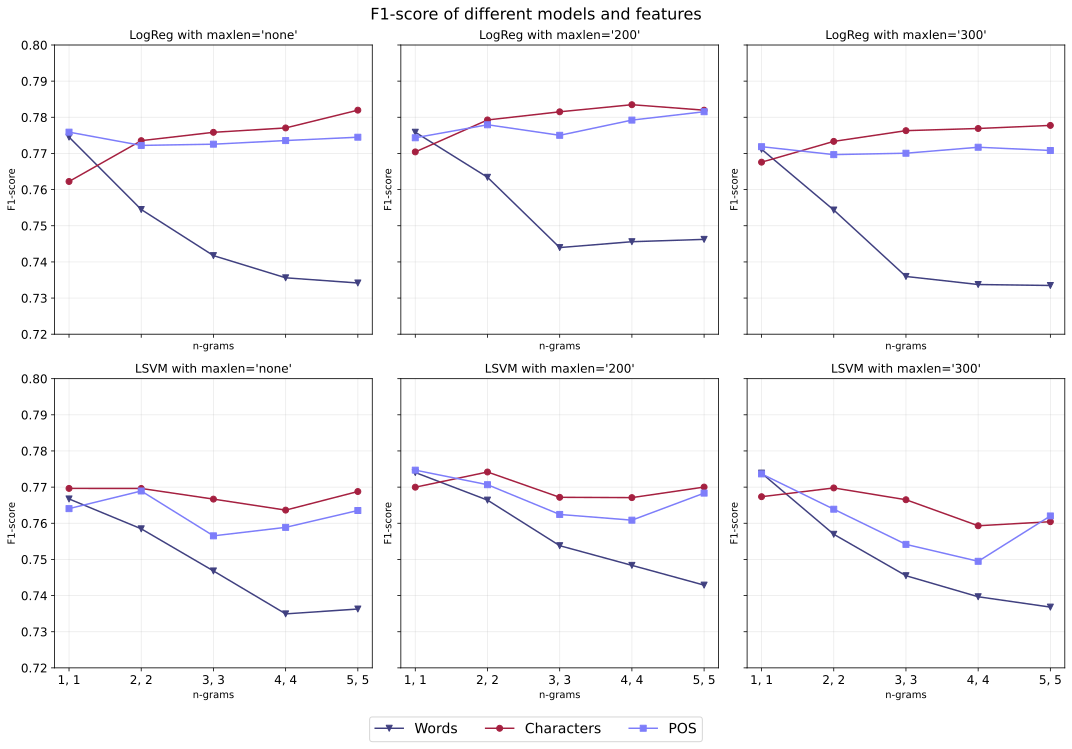

In [12]:
from matplotlib.pyplot import Line2D

markers = {
    "characters": "o", 
    "pos": "s", 
    "words": "v"
}

colors = {
    "characters": "#a52040", 
    "words": "#404080",
    "pos": "#7d7dfa"
}

# make subplots with 2 rows and 3 columns. The rows are for the different models, and the columns for the different features
fig, axes = plt.subplots(2, 3, figsize=(15, 10), sharey=True, sharex=True)

for i, model in enumerate(['LogReg', 'LSVM']):
    for j, maxlen in enumerate(['none', '200', '300']):
        for k, feature in enumerate(['Words', 'Characters', 'POS']):
            df = all_res.loc[(maxlen, feature), model]
            mean = df['F1-score']
            std = df['std']
            n_grams = df.index
            axes[i, j].plot(n_grams, mean, color=colors[feature.lower()], marker=markers[feature.lower()], label=feature)
            # axes[i, j].fill_between(n_grams, mean - std, mean + std, color=colors[feature.lower()], alpha=0.1)
            axes[i, j].set_title(f'{model} with {maxlen=}')
            axes[i, j].set_xticks(n_grams)
            axes[i, j].set_xticklabels([n_gram.replace('n = ', '') for n_gram in n_grams])
            axes[i, j].set_ylim(0.72, 0.80)
            axes[i, j].tick_params(axis='x', labelsize=12)
            axes[i, j].tick_params(axis='y', labelsize=12)
            axes[i, j].set_xlabel('n-grams')
            axes[i, j].set_ylabel('F1-score')
            axes[i, j].grid(zorder=0, alpha=0.25)

# set the title of the figure
fig.suptitle('F1-score of different models and features', fontsize=16)
fig.legend(handles=[Line2D([0], [0], color=colors['words'], marker=markers['words'], label='Words'),
                    Line2D([0], [0], color=colors['characters'], marker=markers['characters'], label='Characters'),
                    Line2D([0], [0], color=colors['pos'], marker=markers['pos'], label='POS')],
              loc='lower center', ncol=3, fontsize=14, bbox_to_anchor=(0.5, -0.05))
# fix legend overlapping with subplots
fig.subplots_adjust(bottom=0.5)
# set the spacing between the subplots and the title
fig.subplots_adjust(top=1.0)
# set the spacing between the subplots
fig.tight_layout()
